In [42]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
plt.style.use(['science','notebook', 'grid'])
import numba
from numba import jit
from scipy.ndimage import convolve, generate_binary_structure

## 1. neg_lattice, pos_lattice =  simulation_inputs()
### fixes initialisation from system size, algorithmic time steps and random probability of up or down-ness

In [219]:
# Global variables and Initialisation

def simulation_inputs():
    
    N = int(input("\n Enter the square system size: "))           # square system size
    M = int(input("\n Enter the number of algorithm steps: "))    # Algorithm time step
    R = .75                           # random probabiliy to initialise the state 
    
    
    init_random = np.random.random((N,N))    # A random N x N lattice is initialised
    lattice_n = np.zeros((N, N))             # lattice of desire is N x N matrix of 0s 

    lattice_n[init_random>=R] = 1            # If a site has greater value than R in random initial state, put 1 or -1 otherwise
    lattice_n[init_random<R] = -1

    init_random = np.random.random((N,N))    # Likely construst a lattice with equal random likelihood but with different majority
    
    lattice_p = np.zeros((N, N))
    lattice_p[init_random<=R] = 1
    lattice_p[init_random>R] = -1
    
    print("\n \n System of size ", N**2, " with randomness of ", R, "has been initialised where simulation will run for ", M, "steps")
    
    return lattice_n, lattice_p, N, M, R

In [208]:
n,p, N, M, R = simulation_inputs()     


# n = negative lattice

# p = positive lattice

# N = square system's size

# M = Algorithm steps

# R = Random uniform distribution of spins as initial state


 Enter the square system size: 50

 Enter the number of algorithm steps: 100000

 
 System of size  2500  with randomness of  0.75 has been initialised where simulation will run for  100000 steps


## 2. get_energy () 
### returns value of energy of a certain configuration

In [220]:
def get_energy(lattice):   # returns energy given a configuration [The Hamiltonian function]
    
    kern = generate_binary_structure(2, 1) 
    kern[1][1] = False
    arr = -lattice * convolve(lattice, kern, mode='constant', cval=0) # applies the nearest neighbours summation
    return arr.sum()

## 3. spins, energies = metropolis (lattice, algo_timeStep, ${\beta J}$, get_energy())

### Runs the initial state towards equilibriation by 
#### A. Randomly flipping one spin
#### B. Calculating corresponding energy value of the lattice
#### C. If energy is same or lower, directly accept the state, but if not accept with Boltzmannian weightage of their energy difference
#### D. Repeat to step A untill M number of iterations has been made

In [210]:
@numba.jit("UniTuple(f8[:], 2)(f8[:,:], i8, f8, f8)", nopython=True, nogil=True)
def metropolis(spin_arr, times, BJ, energy):
    spin_arr = spin_arr.copy()
    net_spins = np.zeros(times-1)   
    net_energy = np.zeros(times-1)
    for t in range(0,times-1):
        # 2. pick random point on array and flip spin
        x = np.random.randint(0,N)
        y = np.random.randint(0,N)
        spin_i = spin_arr[x,y] #initial spin
        spin_f = spin_i*-1 #proposed spin flip
        
        # compute change in energy
        E_i = 0
        E_f = 0
        if x>0:
            E_i += -spin_i*spin_arr[x-1,y]
            E_f += -spin_f*spin_arr[x-1,y]
        if x<N-1:
            E_i += -spin_i*spin_arr[x+1,y]
            E_f += -spin_f*spin_arr[x+1,y]
        if y>0:
            E_i += -spin_i*spin_arr[x,y-1]
            E_f += -spin_f*spin_arr[x,y-1]
        if y<N-1:
            E_i += -spin_i*spin_arr[x,y+1]
            E_f += -spin_f*spin_arr[x,y+1]
        
        # 3 / 4. change state with designated probabilities
        dE = E_f-E_i
        if (dE>0)*(np.random.random() < np.exp(-BJ*dE)):
            spin_arr[x,y]=spin_f
            energy += dE
        elif dE<=0:
            spin_arr[x,y]=spin_f
            energy += dE
            
        net_spins[t] = spin_arr.sum()
        net_energy[t] = energy
            
    return net_spins, net_energy

#### All necessaryy functions are defined so we can start working with the functions

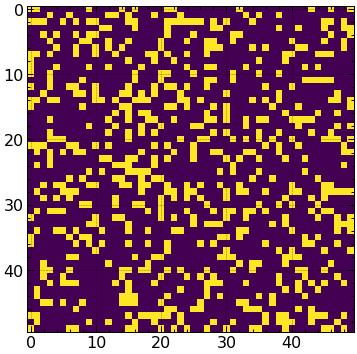

In [224]:
plt.imshow(n)

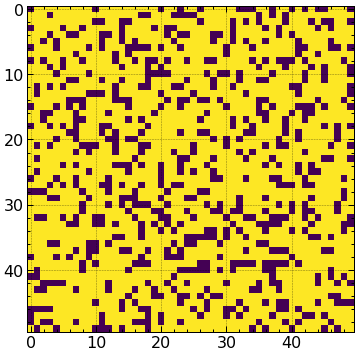

In [225]:
plt.imshow(p)

In [213]:
spins, energies = metropolis(n, M, .10, get_energy(n))   # assigning two lists returning values of equilibriating state's information

In [214]:
%time metropolis(p, M, 0.5, get_energy(p))  # estimate time of computation

CPU times: user 376 ms, sys: 3.98 ms, total: 380 ms
Wall time: 383 ms


(array([1232., 1232., 1234., ..., 2076., 2076., 2076.]),
 array([-2320., -2320., -2324., ..., -5216., -5216., -5216.]))

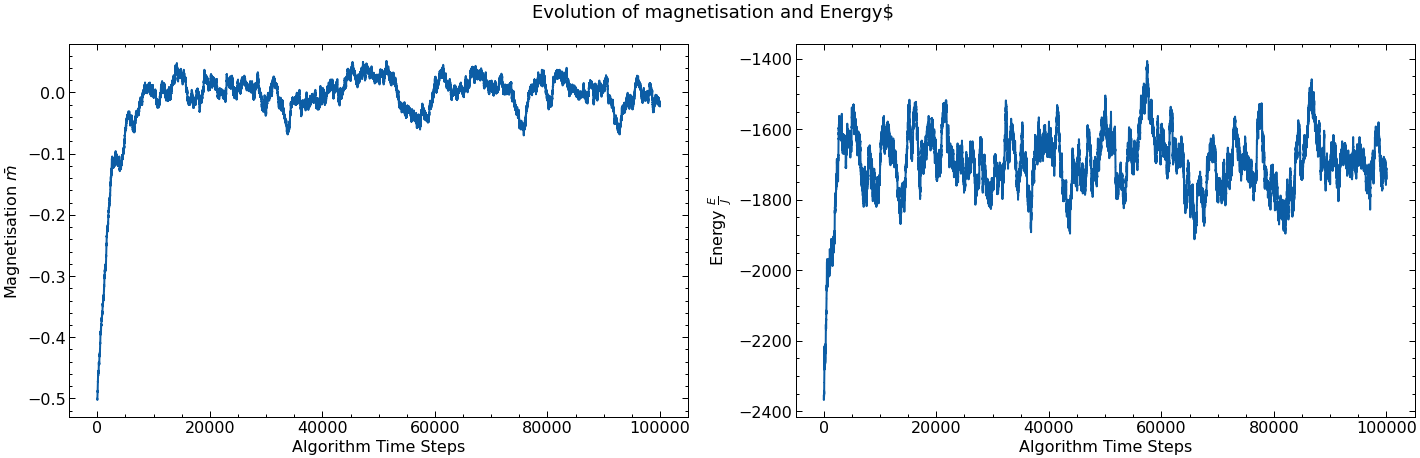

In [215]:
fig, axes = plt.subplots(1, 2, figsize=(20,6))
ax = axes[0]
ax.plot(spins/N**2)
ax.set_xlabel('Algorithm Time Steps')
ax.set_ylabel(r'Magnetisation $\bar{m}$')
ax.grid()
ax = axes[1]
ax.plot(energies)
ax.set_xlabel('Algorithm Time Steps')
ax.set_ylabel(r'Energy $\frac{E}{J}$')
ax.grid()
fig.tight_layout()
fig.suptitle(r'Evolution of magnetisation and Energy$', y=1.07, size=18)
plt.show()

In [216]:
def get_spin_energy(lattice, BJs):
    ms = np.zeros(len(BJs))
    E_means = np.zeros(len(BJs))
    E_stds = np.zeros(len(BJs))
    for i, bj in enumerate(BJs):
        spins, energies = metropolis(lattice, M, bj, get_energy(lattice))
        ms[i] = spins[-M:].mean()/N**2
        E_means[i] = energies[-M:].mean()
        E_stds[i] = energies[-M:].std()
    return ms, E_means, E_stds

In [226]:
BJs = np.arange(0.1, 1,0.05) # Setting temperature range and spacing in simulation   

In [227]:
ms_n, E_means_n, E_stds_n = get_spin_energy(n, BJs)
ms_p, E_means_p, E_stds_p = get_spin_energy(p, BJs)

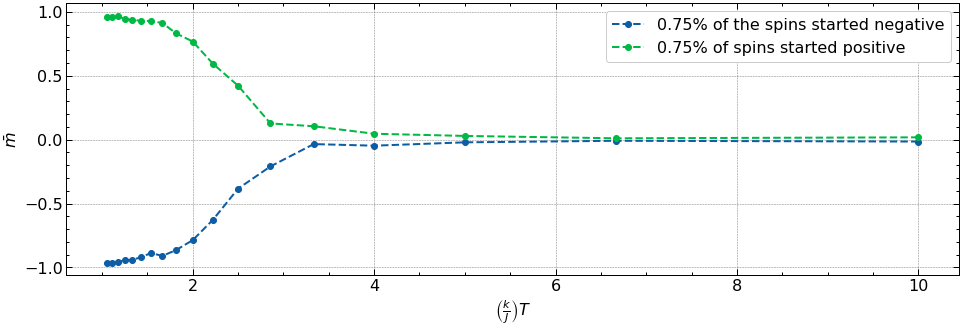

In [229]:
plt.figure(figsize=(16,5))

plt.plot(1/BJs, ms_n, 'o--', label= str(R)+'% of the spins started negative')
plt.plot(1/BJs, ms_p, 'o--', label= str(R)+'% of spins started positive')
plt.xlabel(r'$\left(\frac{k}{J}\right)T$')
plt.ylabel(r'$\bar{m}$')
plt.legend(facecolor='white', framealpha=1)
plt.show()

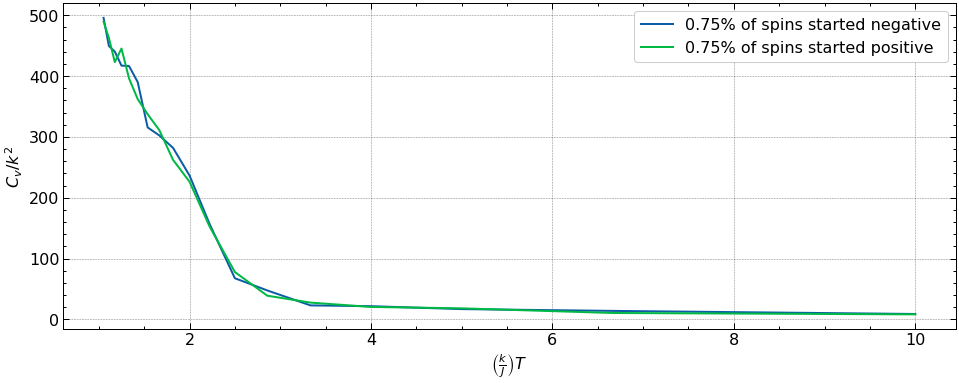

In [230]:
plt.figure(figsize=(16,6))

plt.plot(1/BJs, E_stds_n*BJs, label=str(R)+'% of spins started negative')
plt.plot(1/BJs, E_stds_p*BJs, label=str(R)+'% of spins started positive')
plt.xlabel(r'$\left(\frac{k}{J}\right)T$')
plt.ylabel(r'$C_v / k^2$')
plt.legend()
plt.show()